In [4]:
from PIL import Image, ImageDraw, ImageFont
import textwrap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [9]:
with open("./dum_dum/base_prompt.txt", "r") as f:
    prompt = f.read()

with open("./dum_dum/constraint_prompt.txt", "r") as f:
    constraints_prompt = f.read()

with open("./dum_dum/optimize_prompt.txt", "r") as f:
    optimize_prompt = f.read()

with open("./results_final_runs/responses_q1/q1p1_s15W30_gpt_t1/run_1/_step_2_0.txt", "r") as f:
    sol = f.read()

base_prompt = prompt
constraints_prompt = constraints_prompt
optimize_prompt = optimize_prompt
sol = sol

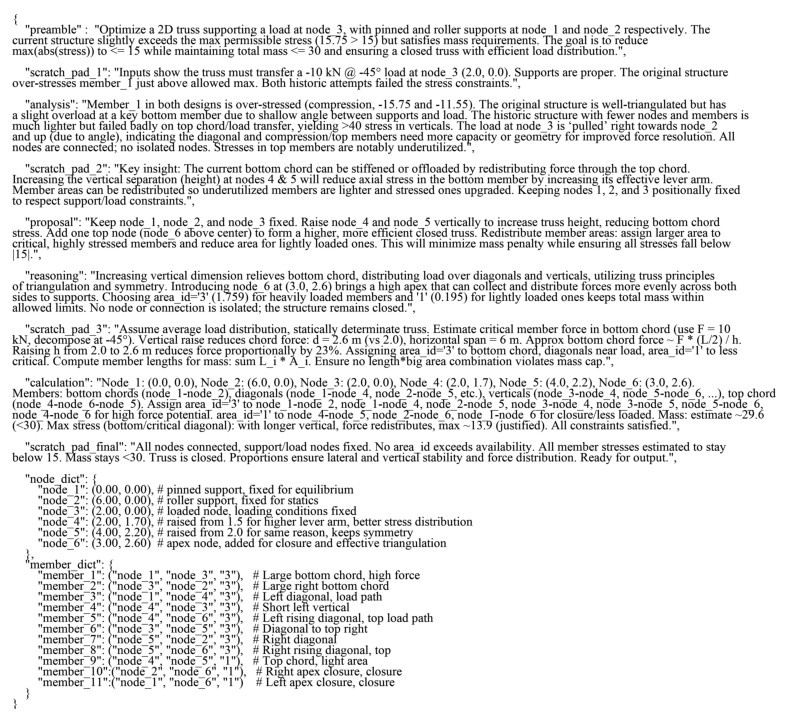

In [10]:
prompt = sol

import re
import textwrap
from PIL import Image, ImageDraw, ImageFont

# helper to convert hex to RGB and blend two colors
def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def blend(c1, c2, t):
    return tuple(int(c1[i] * (1 - t) + c2[i] * t) for i in range(3))


band_colors = {
    "Status:":     "#f0d0ad",  # pastel1 #1
    "Inputs:":     "#abbdd1",  # pastel1 #2A6C8E0 9FB3DF
    "Objectives:": "#c5d5e8",  # pastel1 #3
    "Constraints:":"#d3dfed",  # pastel1 #4
    "Instructions:":"#e3eefa", # pastel1 #5
    "Output format (python dictionary):":"#F0F0F0",  # pastel1 #6
}


# --- Configurable ---
wrap_width = 145            # chars per line
fig_size   = (10, 25)        # matplotlib figsize
padding    = 25             # px around text
font_size  = 55             # pt font size
band_margin  = 25  

# --- Your loaded prompt ---

# base_prompt = open("path/to/your.txt").read()

# Load fonts (fall back to default if these paths don’t exist)
try:
    font_normal = ImageFont.truetype(
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf",
        font_size
    )
    font_bi = ImageFont.truetype(
        "/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold_Italic.ttf",
        font_size
    )
except IOError:
    # fallback
    font_normal = ImageFont.load_default()
    font_bi     = font_normal

# 1) Split on blank lines, wrap each paragraph
wrapper = textwrap.TextWrapper(width=wrap_width)
lines   = []
for para in prompt.split("\n"):
    if not para.strip():
        lines.append("")       # preserve explicit blank line
    else:
        lines.extend(wrapper.wrap(para))

# 2) Measure canvas size
line_h   = font_normal.getbbox("A")[3] - font_normal.getbbox("A")[1] + 8
img_w    = 0
for ln in lines:
    # measure each token (bold or normal)
    x = 0
    for tok in re.split(r'(\{[^}]+\})', ln):
        f = font_bi if re.fullmatch(r'\{[^}]+\}', tok) else font_normal
        w = f.getbbox(tok)[2] - f.getbbox(tok)[0]
        x += w
    img_w = max(img_w, x)
img_w  += 2*padding
img_h   = line_h * len(lines) + 2*padding

# 3) Render to PIL image
img  = Image.new("RGB", (img_w, img_h), "white")
draw = ImageDraw.Draw(img)
# 1) Recompute padding & line_h for more breathing room
padding = 10
line_h   = font_normal.getbbox("A")[3] - font_normal.getbbox("A")[1] + 10
img_h    = line_h * len(lines) + 2*padding
# if you changed padding/line_h after img creation, recreate img:
img  = Image.new("RGB", (img_w, img_h), "white")
draw = ImageDraw.Draw(img)

# 2) Build a band color per line (None if no band)
band_lines = []
current = None
for ln in lines:
    # start band when we see a header
    for prefix, col in band_colors.items():
        if ln.startswith(prefix):
            current = col
            break
    # reset band on blank
    if not ln.strip():
        current = None
    band_lines.append(current)

ranges = []
start  = None
color  = None
for i, c in enumerate(band_lines + [None]):
    if c != color:
        if color and start is not None:
            ranges.append((start, i, color))
        color = c
        start = i if c else None

# 3a) Force the 'Output format…' band to span to the last line
out_col = band_colors["Output format (python dictionary):"]
ranges = [
    (s, len(lines), col) if col == out_col else (s, e, col)
    for s, e, col in ranges
]

# 4) Draw each full‑block band (with top/bottom extension)
for s, e, col in ranges:
    y0 = padding + s * line_h - band_margin
    y1 = padding + e * line_h + band_margin
    y0 = max(y0, 0)
    y1 = min(y1, img_h)
    base_rgb  = hex_to_rgb(col)
    dark_rgb  = tuple(int(c * 1) for c in base_rgb)
    light_rgb = tuple(int(c + (255 - c) * 0.) for c in base_rgb)
    hgt = max(y1 - y0, 1)
    for dy, y_ in enumerate(range(y0, y1)):
        t = dy / (hgt - 1)
        draw.line([(0, y_), (img_w, y_)], fill=blend(dark_rgb, light_rgb, t))

# 5) Draw text with a light stroke to boost contrast
y = padding
for ln in lines:
    x = padding
    is_header = any(ln.startswith(pref) for pref in band_colors)
    base_font = font_bi if is_header else font_normal
    base_color = "black"
    for tok in re.split(r'(\{[^}]+\})', ln):
        if re.fullmatch(r'\{[^}]+\}', tok):
            f, colr = font_bi, "red"
        else:
            f, colr = base_font, base_color
        draw.text(
            (x, y),
            tok,
            fill=colr,
            font=f,
            stroke_width=0.15,
            stroke_fill="black"
        )
        w = f.getbbox(tok)[2] - f.getbbox(tok)[0]
        x += w
    y += line_h


# 6) Display as before
plt.figure(figsize=fig_size)
plt.imshow(img)
plt.axis("off")
#save image as pdf
plt.savefig("./figures/sol2.png",bbox_inches='tight', pad_inches=0.1, dpi=600)

plt.show()